# Basic Task - Q Learning

This file covers the code for the basic tasks of the coursework. We define a custom grid world enviroment, with a maze to be solved in as few steps as possible. We also define two policies: epsilon greedy with decay, and softmax. We run the Q-learning algorithm on the environment using both of these policies, and varying values of gamma and alpha. 

In [2]:
import numpy as np 
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

### The Enviroment

Inspiration for this dungeon environment was gained from the code presented in Labs.

In [3]:
class Maze:
    
    def __init__(self, N=25):
        """
        This class defines a maze environment in a square 2-dimensional numpy array.
        N: dimensions of array, integer, default 25

        There are penalties placed at every dead end in the maze.
        The agent and door are at randomised positions in the maze.
        In the array, these are represented by:
        0: part of the maze path, 1: the agent, 2: maze wall/obstacle, 3: penalty, 4: door
        """
        self.N = N

        # Generating the maze.
        self.grid = np.full((N,N),2)
        self.generate_maze()

        # Placing penalties at every dead end.
        self.penalties_pos = self.generate_penalties()

        for cell in self.penalties_pos:
            self.grid[cell] = 3

        # Adding door and agent at random positions, and getting the current state of the agent.
        self.door_pos = self.get_rand_empty_cells(1)
        self.grid[self.door_pos] = 4

        self.agent_pos = self.get_rand_empty_cells(1)
        self.grid[self.agent_pos] = 1

        self.state = self.get_state(self.agent_pos)

        # Setting a step counter, and the maximum number of steps per episode, which is N squared.
        self.time_elapsed = 0
        self.time_limit = self.N*self.N

        # Defining actions available to the agent.
        self.actions = [('up',-1,0), ('down', 1, 0), ('left', 0, -1), ('right', 0, 1)]

        # Defining the reward and transition matrices for the environment.
        self.reward_matrix, self.transition_matrix = self.get_matrices()

    def generate_maze(self):
        """
        Generate a maze using an iterative depth-first search algorithm. 
        """

        # Making every other cell in the grid a 1, denoting a cell that will be part of the path but hasn't been visuted by the algorithm yet.
            # This means every other cell is currently a wall, and leaves a border of walls around the grid.
        self.grid[1::2, 1::2] = 1

        # Picking a random unvisited cell and making it the current cell
        rand_x = random.randrange(1,self.N,2)
        rand_y = random.randrange(1,self.N,2)
        current_cell = (rand_x, rand_y) 

        self.grid[current_cell] = 0 # Adding the current cell to the maze path.

        cell_stack = [current_cell] # Creating a stack to store cells to be visited by the algorithm.

        # Algorithm runs while there are still cells in the stack to check.
        while len(cell_stack) > 0:
            # Retrieving most recent cell in stack, removing it from stack, and obtaining its unvisited neighbouring path cells.
            current_cell = cell_stack[-1] 
            cell_stack.pop(-1) 
            borders = self.get_nearby_cells(current_cell, dist=2)
            unvisited_borders = [border for border in borders if self.grid[border] == 1]
            # If there are unvisited borders:
            if len(unvisited_borders) > 0:
                cell_stack.append(current_cell) # Add current cell back to stack.
                # Pick bordering cell at random and remove the wall between current cell and that cell, add that cell to stack.
                chosen_cell = random.choice(unvisited_borders) 
                self.grid[(chosen_cell[0] + current_cell[0])//2, (chosen_cell[1] + current_cell[1])//2] = 0
                self.grid[chosen_cell] = 0
                cell_stack.append(chosen_cell)
    
    def generate_penalties(self):
        """
        Return a list of the coordinates of every dead end in the maze.
        """
        penalties_pos = []
        # Iterating through all path cells to check if they are dead ends.
        for i in list(np.argwhere(self.grid == 0)):
            path_cell = tuple(i)
            # Getting bordering cells, and checking which ones are also path cells.
            borders = self.get_nearby_cells(path_cell)
            path_borders = [border for border in borders if self.grid[border] == 0]
            # If there is only one bordering path cell, then it is dead end.
            if len(path_borders) == 1:
                penalties_pos.append(path_cell)
        return penalties_pos

    def get_matrices(self):
        """
        Generate the reward and transition matrices for the environment.

        In the reward matrix, a given value represents the reward that the agent would recieve for taking a given action.
        Reward matrix indices are [current_state, action_index].

        In the transition matrix, a value of 0 means a given action is not allowed, and a 1 means that it is.
        Transition matrix indices are [current_state, action_index, next_state].
 
        Action indices - 0: up 1: down 2: left 3: right
        """
        # Creating arrays to hold matrices - reward is by default -1 for a step, and actions are by default disallowed.
        reward_matrix = -1 * np.ones((self.N*self.N, 4))
        transition_matrix = np.zeros((self.N*self.N, 4, self.N*self.N))

        # Iterating through entire grid.
        for i in range(self.N):

            for j in range(self.N):
                current_cell = (i,j)
                current_cell_type = self.grid[i, j]
                current_state = self.get_state(current_cell)

                for action_index, action_tuple in enumerate(self.actions):
                    next_cell = (i + action_tuple[1], j + action_tuple[2])

                    if self.out_of_bounds(next_cell):
                        next_cell_type = current_cell_type
                        next_state = current_state
                        reward_matrix[current_state, action_index] -= self.N*self.N//4 # Negative reward for going out of bounds.
                        transition_matrix[current_state, action_index, next_state] = 1 # Transition from one state to itself is allowed.
                    else:
                        next_cell_type = self.grid[next_cell]
                        next_state = self.get_state(next_cell)

                    # Transitions to empty path cells, penalties, and the door are allowed.
                    if next_cell_type == 0:
                        transition_matrix[current_state, action_index, next_state] = 1 
                    elif next_cell_type == 2: 
                        reward_matrix[current_state, action_index] -= self.N*self.N//4 # Trying to transition into a wall incurs a negative reward.
                        transition_matrix[current_state, action_index, next_state] = 0
                    elif next_cell_type == 3:
                        reward_matrix[current_state, action_index] -= self.N*self.N//2 # Transitioning into a penality incurs a negative reward.
                        transition_matrix[current_state, action_index, next_state] = 1
                    elif next_cell_type == 4:
                        reward_matrix[current_state, action_index] += self.N*self.N # Transitioning into the door gives a large positive reward.
                        transition_matrix[current_state, action_index, next_state] = 1

        return reward_matrix, transition_matrix 

    def print_reward_matrices(self):
        """
        Display the reward matrices nicely by action.
        """    
        for action_index, action_tuple in enumerate(self.actions):
            print(action_tuple[0])
            print(self.reward_matrix[:, action_index].reshape(self.N, self.N))

    def get_nearby_cells(self, cell, dist=1):
        """
        For a given cell, get the coordinates of all orthogonal cells that are a given distance away.
        dist - distance of desired cells, integer, default 1

        Distance of 1 means returning neighbouring cells.
        """
        cell_up = (cell[0]-dist, cell[1])
        cell_down = (cell[0]+dist, cell[1])
        cell_left = (cell[0], cell[1]-dist)
        cell_right = (cell[0], cell[1]+dist)

        cell_list = [cell_up, cell_down, cell_left, cell_right]

        return [c for c in cell_list if not self.out_of_bounds(c)]

    def out_of_bounds(self, cell):
        """
        Check whether given cell coordinates are out of the bounds of the grid.
        """
        if ((cell[0] < 0) or (cell[0] > self.N-1)) or ((cell[1] < 0) or (cell[1] > self.N-1)):
            return True
        return False

    def get_rand_empty_cells(self, n=1):
        """
        Retreive a random selection of n empty cells from the grid.
        n - integer, default 1

        Returns a list of tuples specifying the coordinates of the selected cells.
        """
        if n == 1:
            zero_cells = np.argwhere(self.grid == 0) # retrieving empty cells
            rand_cell = random.choice(zero_cells)
            rand_cells = tuple(rand_cell)
        else:
            zero_cells = np.argwhere(self.grid == 0) 
            rand_cells = random.choices(zero_cells, k=n)
            rand_cells = [tuple(i) for i in rand_cells]

        return rand_cells

    def get_state(self, cell):
        """
        Return the state number of a given cell.
        States are numbered from 0 to (N*N)-1 (N is the size of the grid),
        starting in the top left and moving left to right along each row to the bottom right.
        """
        state_grid = np.arange(0, self.N*self.N).reshape(self.N, self.N)
        state = state_grid[cell[0], cell[1]]
        return state
    
    def get_cell(self, state):
        """
        Return the cell coordinates of a given state.
        """
        state_grid = np.arange(0, 25*25).reshape(25, 25)
        cell = (state_grid == state).nonzero()
        return cell 

    def display(self):
        """
        Display the grid as an image.
        """
        fig, ax = plt.subplots(figsize=(7*1.61,7))
        cmap = colors.ListedColormap(['white', '#2b52ff','#8f8f8f', '#ff5e5e', '#00cf5a'])
        
        boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
        norm = colors.BoundaryNorm(boundaries, cmap.N)
        plt.imshow(maze.grid, cmap=cmap, norm=norm)
        cell_names = ["Path", "Agent", "Obstacle", "Penalty", "Door"]
        formatter = plt.FuncFormatter(lambda val, loc: cell_names[val])
        cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4], format=formatter)
        cbar.ax.tick_params(labelsize=13)

        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))

        plt.xticks(np.arange(0,25,1))
        plt.yticks(np.arange(0,25,1))
        plt.grid(visible=True, which = 'minor')
        
        plt.show()
    
    
    def step(self, action_index):
        """
        One step in the grid.
        action_index - the index of the action to be taken, 0: up 1: down 2: left 3: right

        Returns:
        end - boolean, whether or not the episode has ended
        reward - integer, the reward for the taken step
        self.state - integer, the new state of the environment after the step
        """
        # Retreive reward value for action from reward matrix.
        reward = self.reward_matrix[self.state, action_index] 
        
        # Work out new position and state if action were to be taken.
        new_pos = (self.agent_pos[0]+self.actions[action_index][1],
                    self.agent_pos[1]+self.actions[action_index][2]) 
        new_state = self.get_state(new_pos)

        self.time_elapsed += 1
        end = False
        door = False

        # If transition matrix says action is allowed, do action.
        if self.transition_matrix[self.state, action_index, new_state] == 1:
            self.grid[self.agent_pos] = 0
            self.agent_pos = new_pos
            self.grid[self.agent_pos] = 1
        
        # If agent has reached the door, terminate episode.
        if self.agent_pos == self.door_pos:
            end = True
            door = True
        
        # If number of steps is over the time limit, end episode.
        if self.time_elapsed > self.time_limit:
            end = True

        self.state = self.get_state(self.agent_pos)

        return end, reward, self.state, door
    
    def reset(self):
        """
        Reset the grid to its original state, but with the agent in a new random position.
        Maze and door remain unchanged.

        Returns the new state of the environment.
        """
        for cell in self.penalties_pos:
            self.grid[cell] = 3

        self.grid[self.door_pos] = 4
        
        self.grid[self.agent_pos] = 0
        self.agent_pos = self.get_rand_empty_cells(1)
        self.grid[self.agent_pos] = 1

        self.time_elapsed = 0

        self.state = self.get_state(self.agent_pos)

        return self.state


### The Policies

In [4]:
class eGreedyDecayPolicy:

    def __init__(self, epsilon = 1, decay = 0.999, min_epsilon = 0.001):
        """
        This class defines an epsilon greedy policy with decay.
        epsilon - float, default 1
        decay - float, default 0.999
        min_epsilon - float, default 0.01

        In the case where decay = 1, epsilon will remain constant.
        In this case:
        If epsilon = 1, the policy will always choose an action randomly.
        If epsilon = 0, the policy will always choose greedily. 
        """
        self.eps_current = epsilon
        self.eps_initial = epsilon
        self.min_eps = min_epsilon
        self.decay = decay

    def __call__(self, state, q_matrix):

        greedy = random.random() > self.eps_current # action is greedy with probability 1 - epsilon

        if greedy:
            action_index = np.argmax(q_matrix[state]) 
        
        else:
            action_index = random.randint(0, 3)
        
        return action_index
    
    def update(self):
        """
        Decay epsilon
        """
        self.eps_current = self.eps_current*self.decay
        
        if self.eps_current < self.min_eps:
            self.eps_current = self.min_eps

    def reset(self):
        self.eps_current = self.eps_initial

In [5]:
class softmaxPolicy:
    """
        This class defines a softmax policy with decay.
        temp - float, default 5
        decay - float, default 0.99
        min_epsilon - float, default 0.01

        In the case where decay = 1, temperature will remain constant. 
        """
    def __init__(self, temp=5, decay=0.99, min_temp = 0.001):
        self.temp_current = temp
        self.temp_initial = temp
        self.min_temp = min_temp
        self.decay = decay
    
    def __call__(self, state, q_matrix):

        e = np.exp(q_matrix[state]/self.temp_current)
        prob_actions = e / np.sum(e) # calculating probabilities from boltzmann distribution

        if not np.isnan(prob_actions).any(): # checking all probs have been calculated
            action_index = np.random.choice(range(4),p = prob_actions)
        else:
            action_index = np.argmax(q_matrix[state]) # greediest action
            
        return action_index
    
    def update(self):
        """
        Decay temperature
        """
        self.temp_current = self.temp_current*self.decay
        
        if self.temp_current < self.min_temp:
            self.temp_current = self.min_temp

    def reset(self):
        self.temp_current = self.temp_initial

### The Q-learning Algorithm

In [6]:
def runQLearning(env, policy, alpha = 0.5, gamma = 0.5, min_eps=100, max_eps = 10000):
    """
    Run the Q-learning algorithm for a given environment using a given policy.
    alpha - float, default 0.5
    gamma - float, default 0.5
    min_eps - minimum number of episodes, integer, default 100
    max_eps - maximum number of episodes, integer, default 10000
    """

    q_matrix = np.zeros( (env.N*env.N, 4) ) # Initialise empty Q-matrox
    converged = False
    eps = 0
    rew = []
    doors = []

    while not converged: # run algorithm until convergence

        # checking what policy was used so values can be printed
        if isinstance(policy, eGreedyDecayPolicy):
            param = policy.eps_current
        elif isinstance(policy, softmaxPolicy):
            param = policy.temp_current 

        eps += 1
        policy.update()
        state = env.reset()
        end = False 
        step_rewards = []

        while not end: # running one episode
            # selecting action and making step
            action_index = policy(state, q_matrix)
            end, reward, new_state, door = env.step(action_index)

            # the q-learning algorithm!
            q_matrix[state, action_index] = q_matrix[state, action_index] + \
                alpha * (reward + gamma * np.max(q_matrix[new_state, :]) - q_matrix[state, action_index]) 

            state = new_state
            step_rewards.append(reward)

        ep_reward = np.array(step_rewards).sum()
        rew.append(ep_reward)
        doors.append(door)

        val_matrix = np.zeros( (env.N, env.N) ) # initialising empty value matrix to hold highest q value for each state
        for i in range(env.N):
            for j in range(env.N):
                state = env.get_state([i,j])
                val_matrix[i,j] = max(q_matrix[state]) 
                val_matrix[i,j] = max(q_matrix[state])
        
        
        if eps > min_eps:
            prev_100 = rew[-100:] # using previous 100 episodes' rewards
            std = np.std(prev_100)
            mean = np.mean(prev_100)
            print(env.N*env.N)
            print(f"std:{std}, mean: {mean}")

            if std < env.N*env.N and mean > 0: # checking for convergence using reward mean and std 
                converged = True
        
        if eps == max_eps: # stop running if we reach the maximum number of episodes
            converged = True
            print("Did not converge")


        print(f"Episode {eps} finished. reward: {ep_reward}. param: {param}. door: {door}")

    return eps, rew, val_matrix, q_matrix, doors

In [7]:
def calculate_rolling_av(x, n):
    """
    Calculate a rolling average with n datapoints for some data x.
    """
    cumsum = np.cumsum(np.insert(x, 0, 0))
    rolling_av = (cumsum[n:] - cumsum[:-n]) / float(n)
    return rolling_av
    
def plot_results(rewards):
    """
    Plot the reward for each episode with a rolling average containing 50 datapoints.
    """
    fig, ax = plt.subplots(figsize=(5*1.61, 5))

    ax.plot(rewards, lw=0.75, alpha=0.6, color="#4575b4", label = "Total reward for each episode")

    ax.set_xlabel("Episode", fontsize=12)
    ax.set_ylabel("Reward", fontsize=12)

    ax.grid()
    
    n = len(rewards)//50
    rolling_av = calculate_rolling_av(rewards, n)

    ax.plot(rolling_av, lw=2, color = "#d73027", label = f"Rolling average of every {len(rewards)//50} episodes' rewards")
    ax.legend(fontsize=12)
    
    

### Running the algorithm and representing its performance

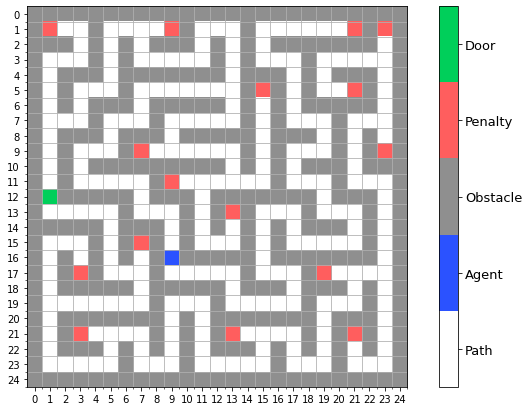

In [8]:
# Initialising the environment
random.seed(420)
maze = Maze(25)
maze.display()

In [ ]:
# Running epsilon greedy policy with default parameters
random.seed(420)
eps_policy = eGreedyDecayPolicy()
eps_eps, rew_eps, val_matrix_eps, q_matrix_eps, doors_eps = runQLearning(env=maze, policy=eps_policy)

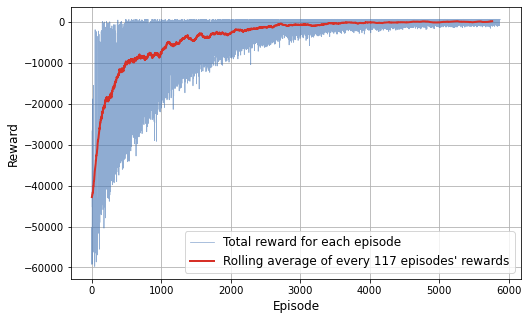

In [145]:
plot_results(rew_eps)

In [ ]:
# Running softmax policy with default parameters
random.seed(420)
softmax_policy = softmaxPolicy(temp=5, decay=0.99)
eps, rew, val_matrix, q_matrix, doors = runQLearning(env=maze, policy=softmax_policy)

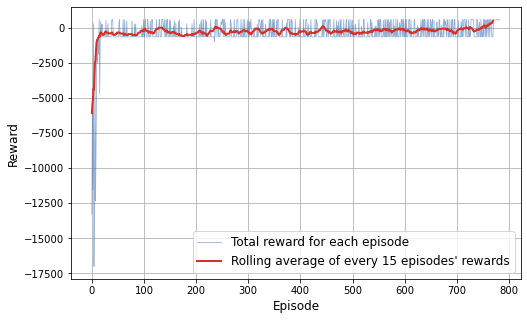

In [146]:
plot_results(rew)

### Parameter Tuning

In [ ]:
# Running grid search over different values of alpha and gamma
eps_decay_policy = eGreedyDecayPolicy()
alpha = np.arange(0.1,1.0,0.2)
gamma = np.arange(0,1.1,0.2)

data = []

for a in alpha:
    for g in gamma:
        eps_decay_policy.reset()
        eps, rew, val_matrix, doors = runQLearning(maze, eps_decay_policy, gamma=g, alpha=a)
        data.append(eps)

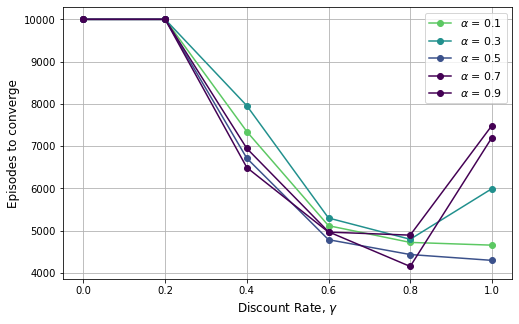

In [85]:
# Plotting results 
cmap=plt.cm.get_cmap('viridis_r', 5)

gamma = np.arange(0,1.1,0.2)
fig, ax = plt.subplots(figsize=(5*1.61, 5))
for i,d in enumerate(data):
    ax.plot(gamma, d, '-o', color = cmap(i+1), label = fr"$\alpha$ = {alpha[i]}")

ax.set_xlabel(r"Discount Rate, $\gamma$", fontsize=12)
ax.set_ylabel("Episodes to converge", fontsize=12)
ax.legend(fontsize=11)
ax.grid()
plt.show()

In [ ]:
# Running grid search over smaller window

alpha = np.arange(0.5,0.8,0.1)
gamma = np.arange(0.6,0.9,0.1)

data = []

for a in alpha:
    for g in gamma:
        eps_decay_policy.reset()
        eps, rew, val_matrix, doors = runQLearning(maze, eps_decay_policy, gamma=g, alpha=a)
        data.append(eps)

### Running with tuned parameters

In [ ]:
random.seed(420)
eps_policy = eGreedyDecayPolicy()
eps_eps, rew_eps, val_matrix_eps, q_matrix_eps, doors_eps = runQLearning(env=maze, policy=eps_policy, gamma = 0.8, alpha =0.5)

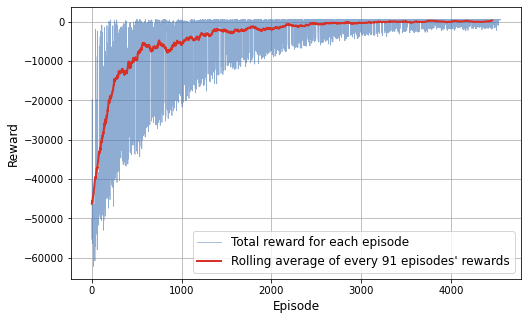

In [43]:
plot_results(rew_eps)

In [44]:
def runOptimalPolicy(env, q_matrix):
    """
    Run greedy policy based on given Q-matrix in a given environment
    """
    state = env.get_state(env.agent_pos)
    state_list = [state]
    end = False 
    steps = 0
    while not end:
        action_index = np.argmax(q_matrix[state])
        end, reward, new_state, door = env.step(action_index)
        steps += 1
        state = new_state
        state_list.append(state)
    return steps, state_list, reward

In [45]:
def runOptimalPolicyLoads(env, q_matrix, episodes = 1000):
    """
    Run greedy policy based on given Q-matrix in a given environment over several episodes
    """
    steps_list = []
    reward_list = []
    for i in range(episodes):
        env.reset()
        steps, state_list, reward = runOptimalPolicy(env, q_matrix)
        steps_list.append(steps)
        reward_list.append(reward)
    return steps_list, reward_list

In [46]:
# Running optimal policy on exact starting position from earlier
random.seed(420)
maze = Maze(25)
steps, state_list, reward = runOptimalPolicy(maze, q_matrix_eps)
cells_visited = []
for state in state_list:
    cell = maze.get_cell(state)
    maze.grid[cell[0], cell[1]] = 5

In [47]:
steps

58

In [48]:
# Running optimal policy from 1000 randomised start positions
steps, rewards = runOptimalPolicyLoads(maze, q_matrix_eps)

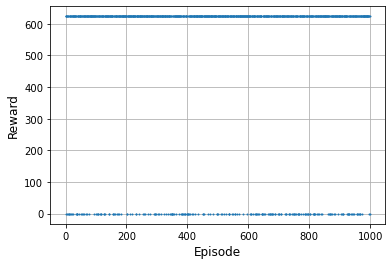

In [49]:
# Visualising results
plt.plot(rewards, 'o', ms ='1')
plt.grid()
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Reward", fontsize = 12)
plt.show()

In [50]:
np.sum(np.array(rewards)>600)

788